# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from matplotlib.cm import Blues
import seaborn as sns
sns.set_theme()
colors = sns.color_palette("deep")
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# statsmodels
from statsmodels.tsa.stattools import adfuller

# Custom
%load_ext autoreload
%autoreload explicit
%aimport probability_calibration, utils
from probability_calibration import calibrate_proba_monthly_recal
from utils import vertically_concatenate_images

## Parameters

In [37]:
scope = 'BID'

model = 'RF'
extension = '.pkl'
input_path = f'../data/2_processed/ML_dataset_{scope}.pkl'
predictions_path = f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m{extension}'
cal_save_folder = f'{scope}/model_dumps/calibrator'

start_month = 202001
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [38]:
def AUCPR(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

def Precision(groupby):
    return precision_score(groupby[target], (groupby['y_probs'] >= 0.5))

def Recall(groupby):
    return recall_score(groupby[target], (groupby['y_probs'] >= 0.5))

def F1(groupby):
    return f1_score(groupby[target], (groupby['y_probs'] >= 0.5))

In [39]:
def get_score_per_group(
        df,
        group,
        score=AUCPR,
        plot=True,
        plot_kind='bar',
        plot_trend=False,
        hide_xlab=True,
        plot_baseline=False,
        ylab=None,
        save_fig=False,
        **kwargs
    ):
    score_df = df.groupby(group, as_index=False).apply(score).rename({None: score.__name__}, axis=1)
    score_df.sort_values(group, inplace=True)
    score_df[group[0]] = score_df[group[0]].astype(str)
    if plot:
        fig, ax = plt.subplots()
        if len(group) > 1:
            score_df.pivot(index=group[0], columns=group[1], values=score.__name__).plot(kind='bar', ax=ax, **kwargs)
        else:
            score_df.set_index(group[0]).plot(kind=plot_kind, legend=False, ax=ax, **kwargs)
        if plot_trend:
            mean_score = score_df[score.__name__].mean()
            ax.axhline(y=mean_score, linestyle='--', color='red', linewidth=1)
            # Add annotation for correlation coefficient
            ax.annotate('$\mu = {:.2f}$'.format(mean_score), xy=(0.78, 0.81), xycoords='axes fraction',  
            xytext=(20, 20), textcoords='offset points',  fontsize=14, color='red')
        if plot_baseline:
            ax1 = ax.twinx()
            rate_df = df.groupby(group, as_index=False)["Result"].mean()
            rate_df[group[0]] = rate_df[group[0]].astype(str)
            ax1.plot(rate_df[group[0]], rate_df.Result, color='black', linewidth=1, markersize=3, label='Prior probability')
            ax1.set_ylabel('Prior probability')
            ax1.set_ylim((0, 0.06))
            ax.grid(False)
            ax1.grid(False)
        if hide_xlab:
            plt.xlabel(None)
        plt.xticks(rotation=0)
        if ylab:
            plt.ylabel(ylab)
        else:
            plt.ylabel(score.__name__)
        # plt.ylim((0,1))
        ax.set_ylim((0, 1))
        # plt.title('{} bids APS per {}'.format(scope, group[0]))
        # plt.tight_layout()
        if save_fig:
            plt.savefig('../plots/{}/precision_recall/{}_{}_{}_{}.png'.format(scope, model, score.__name__, '_'.join(group), scope.lower()), bbox_inches='tight')
        plt.show()

    return score_df

In [40]:
def get_acc_rate_per_group(df, group, plot=True, save_fig=False, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.tight_layout()
        if save_fig:
            plt.savefig('../plots/{}/{}_acc_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

# Main

## Load dataset & model predictions

In [41]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df['Month'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty,yearmonth,month,Month
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,0.095,0.095,26.22,-0.349,False,0.000000,22.000,201801,1,2018-01
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,0.095,0.095,26.22,-0.329,False,0.000000,22.000,201801,1,2018-01
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,0.095,0.095,26.22,-0.324,False,0.000000,22.000,201801,1,2018-01
2018010117UP_ARSIE_1_BID,17,20180101,2018,UP_ARSIE_1,BID,3.456008,0.661794,-2.372137,-0.624680,3.037220,...,0.627,0.627,0.00,-1.000,False,0.000000,15.800,201801,1,2018-01
2018010118UP_ARSIE_1_BID,18,20180101,2018,UP_ARSIE_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,1.000,1.000,0.00,-1.000,False,0.000000,27.000,201801,1,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,17,20221231,2022,UP_VOGHERA_1,BID,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,0.540,0.540,135.00,-0.350,False,0.000000,4.491,202212,12,2022-12
2022123118UP_VOGHERA_1_BID,18,20221231,2022,UP_VOGHERA_1,BID,0.055686,-2.259989,-1.329127,0.607693,-2.561474,...,1.000,1.000,136.00,-0.420,True,0.222876,186.000,202212,12,2022-12
2022123119UP_VOGHERA_1_BID,19,20221231,2022,UP_VOGHERA_1,BID,-0.051126,-2.357014,-1.293692,0.548271,-2.484197,...,1.000,1.000,138.00,-0.414,True,0.244465,187.000,202212,12,2022-12
2022123120UP_VOGHERA_1_BID,20,20221231,2022,UP_VOGHERA_1,BID,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,...,1.000,1.000,141.00,-0.405,True,0.176471,187.000,202212,12,2022-12


In [42]:
# Load model predictions
if extension == '.csv':
    y_probs = pd.read_csv(predictions_path, index_col=0)
else:
    y_probs = pd.read_pickle(predictions_path)
# Below some obs could be dropped as NA as they were not in the prediction process
df['y_probs'] = y_probs

## Calibration curves

In [43]:
test_df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
test_df['y_probs_cal'] = calibrate_proba_monthly_recal(df, start_month, end_month, save_folder=cal_save_folder)
# Sometimes the isotonic regression creates na so in this case we simply take the uncalibrated y
cal_is_na = test_df.y_probs_cal.isna()
test_df.loc[cal_is_na, 'y_probs_cal'] = test_df.loc[cal_is_na, 'y_probs']
print(f"{cal_is_na.sum()} observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.")

100%|██████████| 36/36 [00:02<00:00, 17.30it/s]


3 observations have a NaN calibrated value. For these observations, y_probs_cal was set to y_probs.


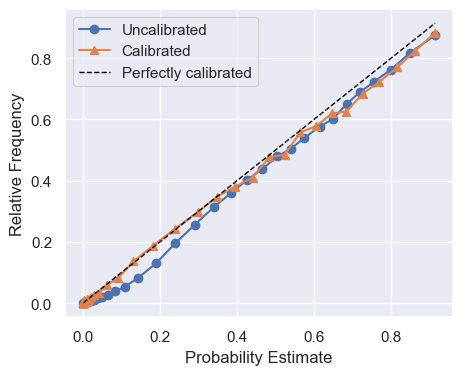

In [44]:
n_bins = 50
plt.figure(figsize=(5,4))
prob_true, prob_pred = calibration_curve(test_df.Result, test_df.y_probs, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

prob_true_cal, prob_pred_cal = calibration_curve(test_df.Result, test_df.y_probs_cal, n_bins=n_bins, strategy='quantile')
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred_cal, prob_pred_cal, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Probability Estimate')
plt.ylabel('Relative Frequency')
plt.legend()

plt.savefig(f"../plots/{scope}/rd_{scope}.png", bbox_inches='tight') 

In [45]:
test_df.y_probs_cal.to_pickle(f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m_CALIBRATED.pkl')

## Performance analysis

### Overall performance per year

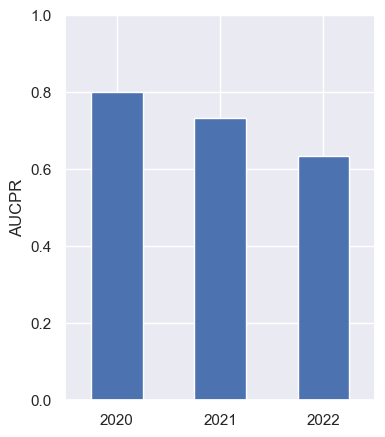

In [46]:
aps_df = get_score_per_group(test_df, group=['year'], figsize=(4,5))

In [47]:
aps_df

,year,AUCPR
0,2020,0.800287
1,2021,0.733015
2,2022,0.634273


### Overall performance per hour

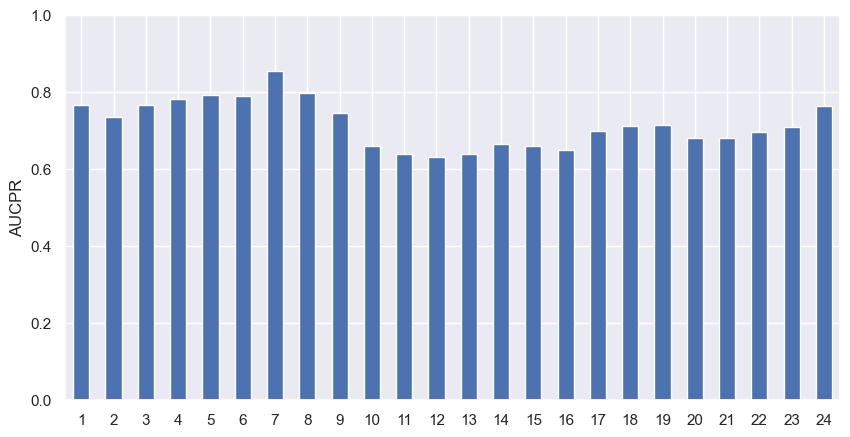

,hour,AUCPR
0,1,0.764859
1,2,0.734897
2,3,0.765996
3,4,0.781369
4,5,0.792251
5,6,0.790086
6,7,0.852984
7,8,0.797757
8,9,0.745783
9,10,0.658876


In [48]:
aps_df = get_score_per_group(test_df, group=['hour'], figsize=(10,5))
aps_df

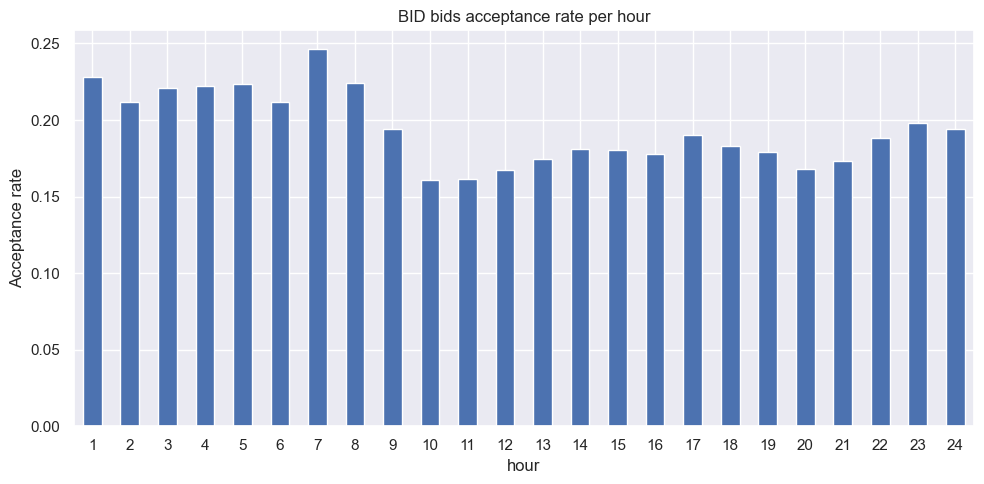

,hour,Result
0,1,0.227889
1,2,0.212088
2,3,0.221130
3,4,0.222449
4,5,0.223361
5,6,0.211714
6,7,0.246210
7,8,0.224018
8,9,0.194211
9,10,0.160520


In [49]:
acc_df = get_acc_rate_per_group(test_df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate is not really driving the variability in the performance of the model

### Overall performance per month

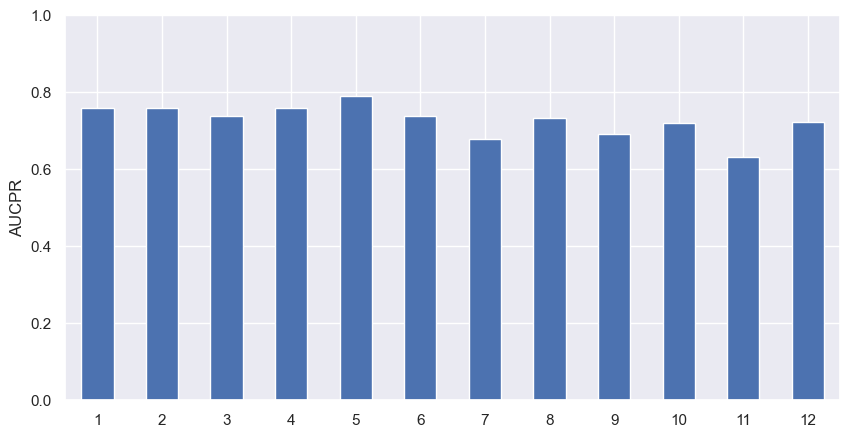

,month,AUCPR
0,1,0.758646
1,2,0.756665
2,3,0.737466
3,4,0.757263
4,5,0.788627
5,6,0.737995
6,7,0.677544
7,8,0.731974
8,9,0.691426
9,10,0.717855


In [50]:
aps_df = get_score_per_group(test_df, group=['month'], figsize=(10,5))
aps_df

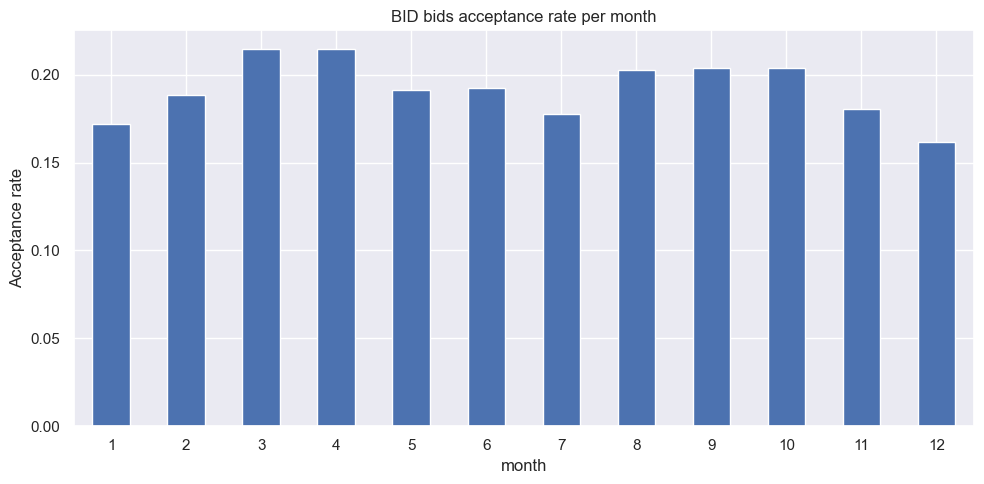

,month,Result
0,1,0.172150
1,2,0.188537
2,3,0.214390
3,4,0.214493
4,5,0.191101
5,6,0.192343
6,7,0.177795
7,8,0.202685
8,9,0.203992
9,10,0.204115


In [51]:
acc_df = get_acc_rate_per_group(test_df, ["month"], figsize=(10,5))
acc_df

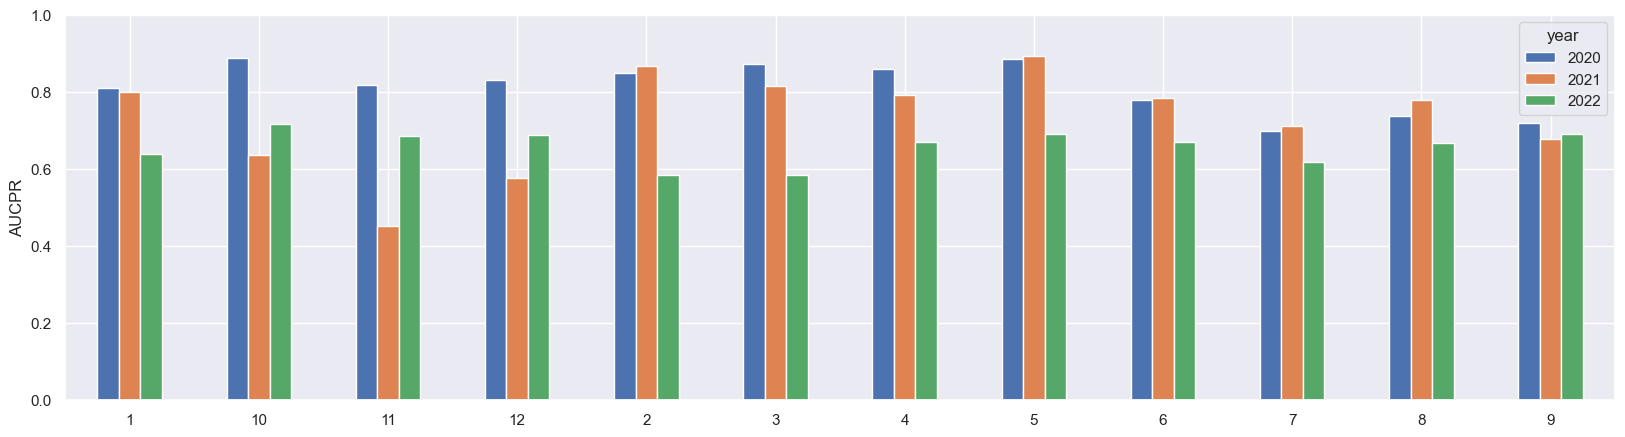

In [52]:
aps_df = get_score_per_group(test_df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

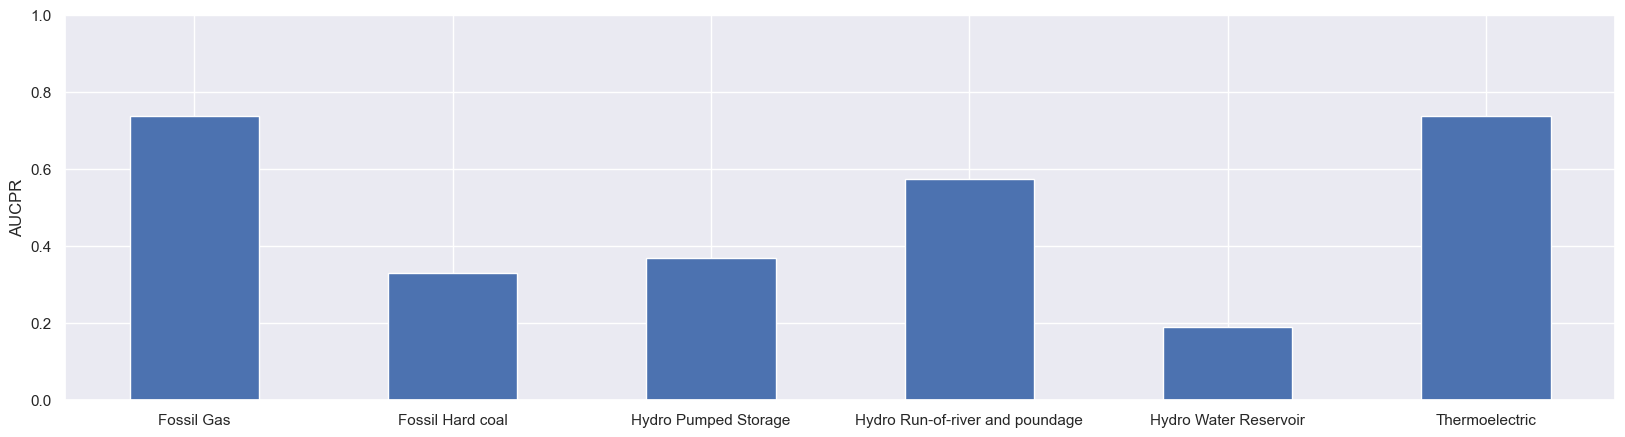

,Tech,AUCPR
0,Fossil Gas,0.735954
1,Fossil Hard coal,0.328850
2,Hydro Pumped Storage,0.367152
3,Hydro Run-of-river and poundage,0.574396
4,Hydro Water Reservoir,0.188827
5,Thermoelectric,0.735918


In [53]:
aps_df = get_score_per_group(test_df, group=['Tech'], figsize=(20,5))
aps_df

In [54]:
test_df.Tech.value_counts()

Tech
Fossil Gas                         450869
Hydro Pumped Storage               274532
Hydro Water Reservoir              224520
Hydro Run-of-river and poundage    125686
Thermoelectric                      48784
Fossil Hard coal                    20831
Name: count, dtype: int64

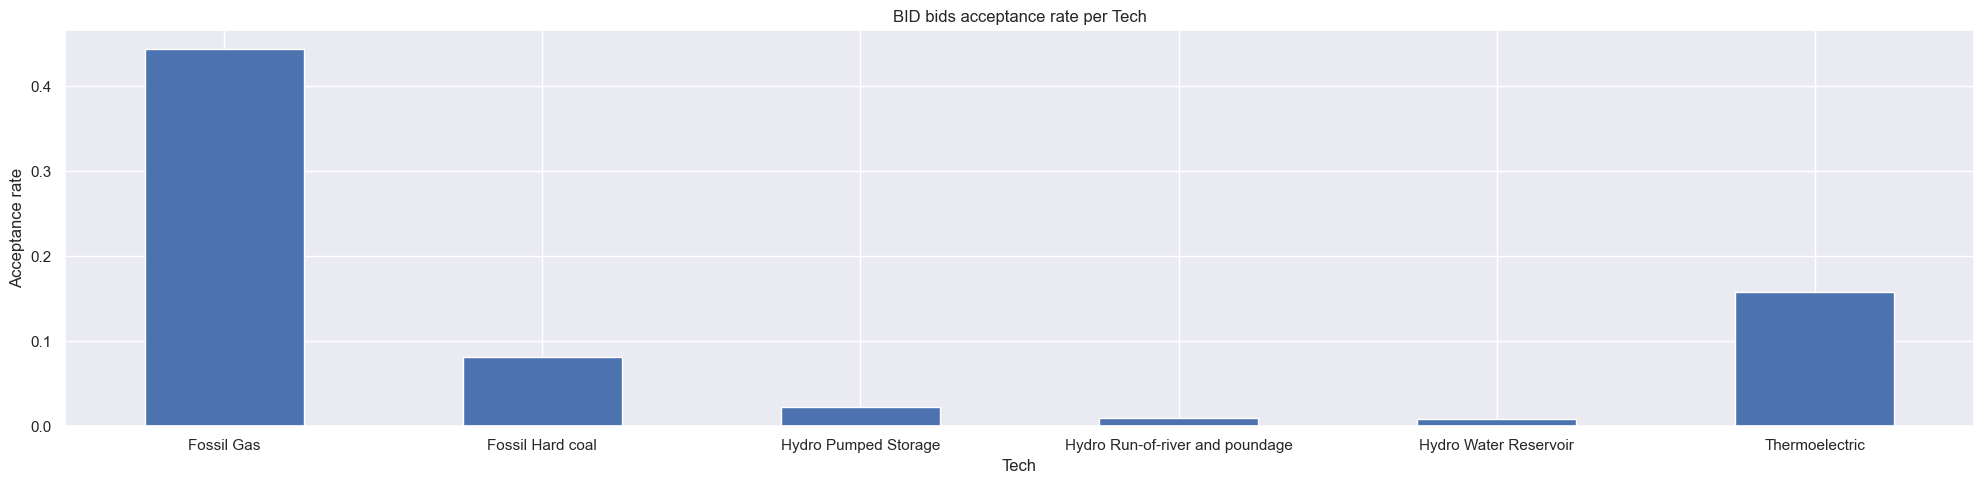

In [55]:
acc_df = get_acc_rate_per_group(test_df, ["Tech"], figsize=(20,5))

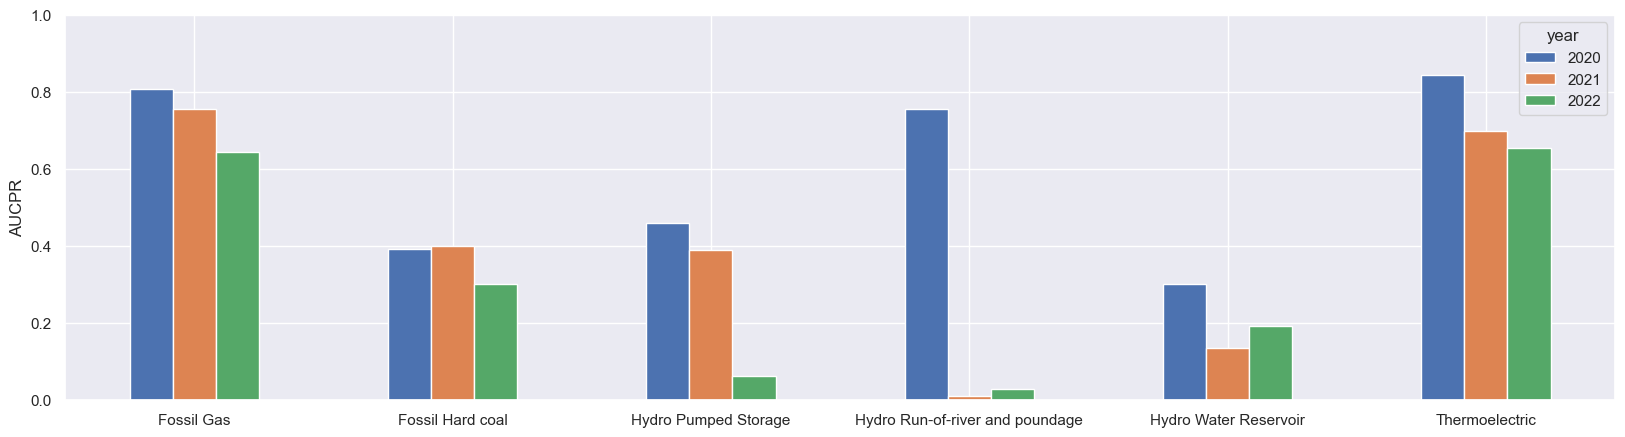

In [56]:
aps_df = get_score_per_group(test_df, group=['Tech', 'year'], figsize=(20,5))

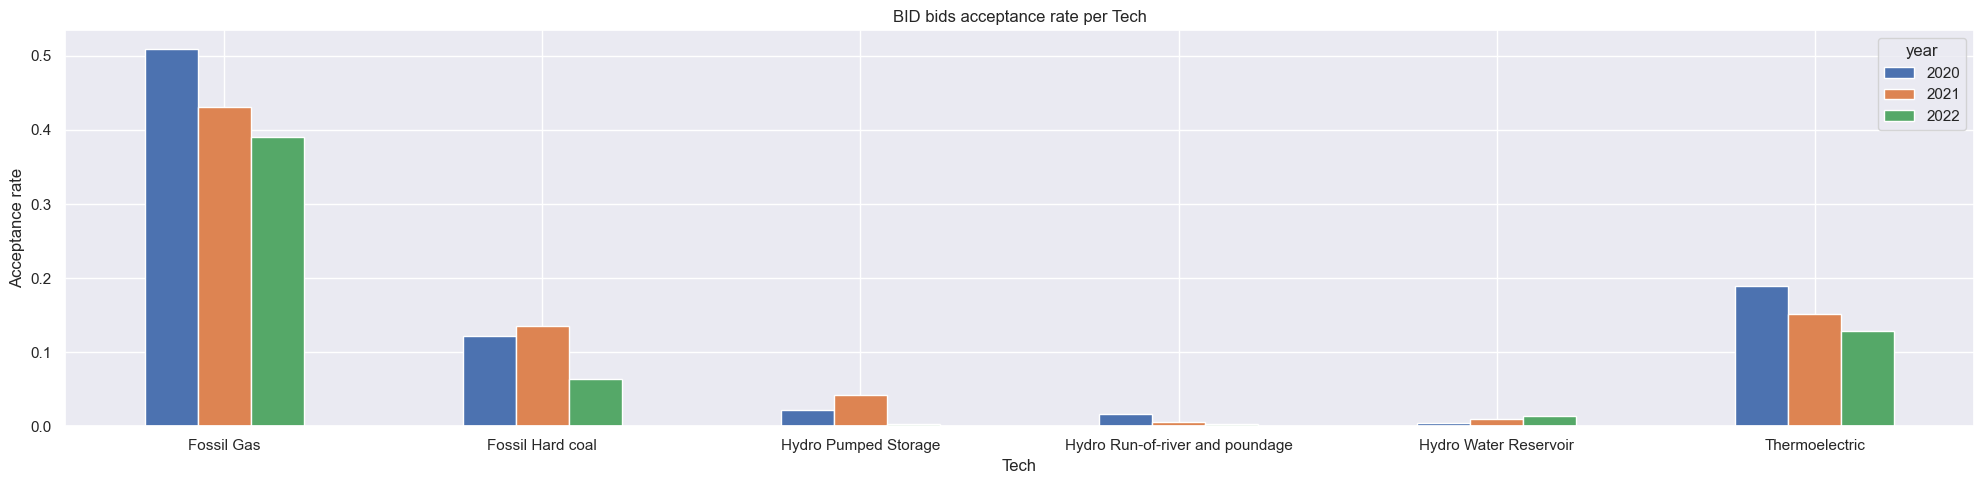

In [57]:
acc_df = get_acc_rate_per_group(test_df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

From now on the probability calibration matters and we set `y_probs` to `y_probs_cal`

In [58]:
test_df['y_probs'] = test_df['y_probs_cal']
test_df.drop('y_probs_cal', axis=1, inplace=True)

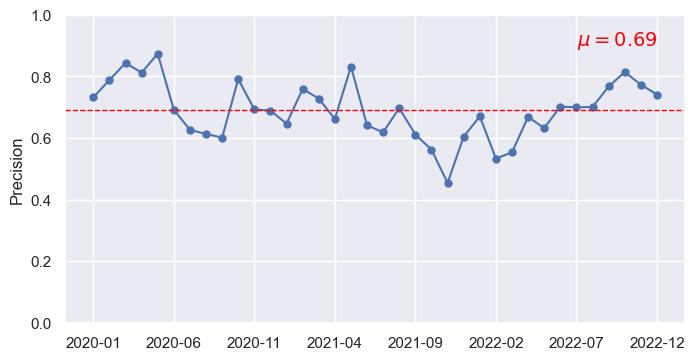

In [59]:
precision_df = get_score_per_group(test_df, score=Precision, group=['Month'], plot_kind='line', figsize=(8,4), marker='o', markersize=5, plot_trend=True, save_fig=True)

In [60]:
adfuller(precision_df.Precision)

(-1.5486540540243667,
 0.5093204437302654,
 7,
 28,
 {'1%': -3.6889256286443146,
  '5%': -2.9719894897959187,
  '10%': -2.6252957653061224},
 -54.56832231458216)

array([[<Axes: title={'center': 'Precision'}>]], dtype=object)

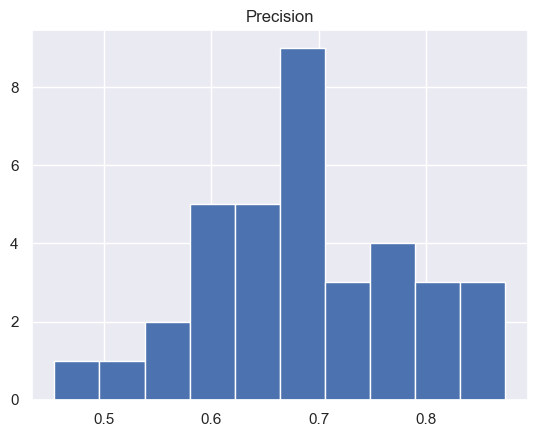

In [61]:
precision_df.hist()

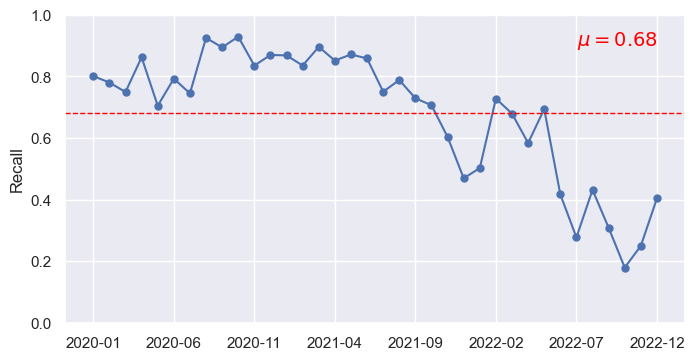

In [62]:
recall_df = get_score_per_group(test_df, score=Recall, group=['Month'], plot_kind='line', plot_trend=True, figsize=(8,4), marker='o', markersize=5, save_fig=True)

In [63]:
adfuller(recall_df.Recall)

(-0.12682870312986794,
 0.9466998545395636,
 2,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 -37.97070858769132)

array([[<Axes: title={'center': 'Recall'}>]], dtype=object)

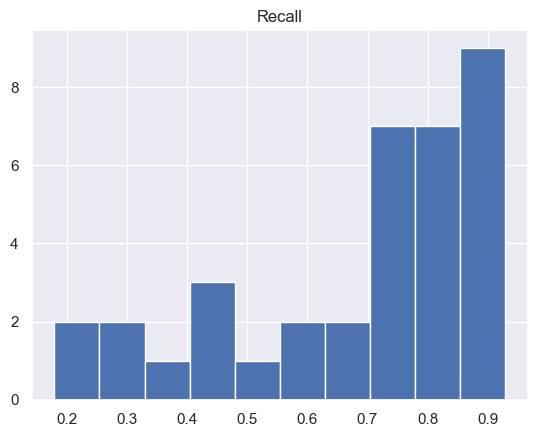

In [64]:
recall_df.hist()

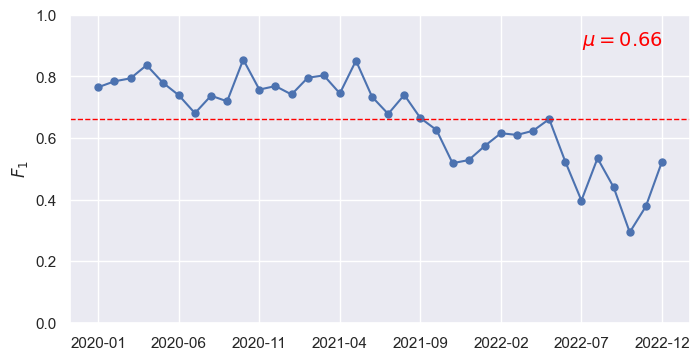

In [65]:
f1_df = get_score_per_group(test_df, score=F1, group=['Month'], plot_kind='line', figsize=(8,4), plot_trend=True, ylab='$F_1$', marker='o', markersize=5, save_fig=True)

In [66]:
adfuller(f1_df.F1)

(-0.45864841444796434,
 0.8998365268085269,
 2,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 -51.9762879202371)

array([[<Axes: title={'center': 'F1'}>]], dtype=object)

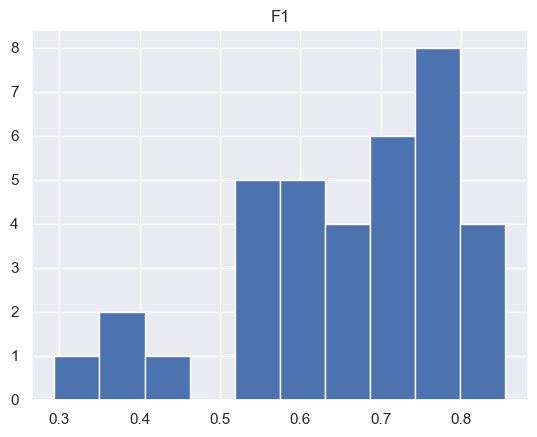

In [67]:
f1_df.hist()

Combine images together using utils function

In [68]:
images_path = ['../plots/{}/precision_recall/{}_{}_Month_{}.png'.format(scope, model, score, scope.lower()) for score in ['Precision', 'Recall', 'F1']]
output_path = '../plots/{}/precision_recall/prf1_{}.png'.format(scope, scope.lower())

vertically_concatenate_images(images_path, output_path)

# clean
for img in images_path:
    os.remove(img)

<HR>

# TESTS